<a href="https://www.kaggle.com/code/priyanagda/getting-started-understanding-data?scriptVersionId=96298254" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

## This Notebook is for visualizing and understanding the data available.

NOTE: Apart from a little code cleaning, the notebook is complete.

## Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import os
from glob import glob
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from albumentations import HorizontalFlip, VerticalFlip, Rotate
import tqdm
import cv2

from pylab import rcParams

rcParams['figure.figsize'] = 18, 8

%matplotlib inline

## Loading the dataset

In [ ]:
train_data = pd.read_csv('../input/uw-madison-gi-tract-image-segmentation/train.csv')

In [ ]:
train_data.head()

In [ ]:
train_images = glob('../input/uw-madison-gi-tract-image-segmentation/train/*/*/*/*')

In [ ]:
len(train_images)

In [ ]:
train_images[0]

## Plotting a few images to visualize data randomly

**Each case has 144 scans, with a few being segmentation masks.
It is to be noted that not all cases have masks**

In [ ]:
image = cv2.imread(train_images[0], cv2.IMREAD_UNCHANGED)
plt.imshow(image)

In [ ]:
image = cv2.imread(train_images[143], cv2.IMREAD_UNCHANGED)
plt.imshow(image)

In [ ]:
image = cv2.imread(train_images[1], cv2.IMREAD_UNCHANGED)
plt.imshow(image)

## Run Length Encoding (RLE) images decoding

The segmentation (where doesn't have the value nan) is formed by a list of numbers containing different pixel points and their length. As an example:

'28094 3 28358 7 28623 9 28889 9 29155 9 29421 9 29687 9 29953 9 30219 9 30484 10 30750 10 31016 10 31282 10 31548 10 31814 10 32081 9 32347 8 32614 6'

where:

28094, 28358, 28623 etc. are the startpoints of the pixels within the matrix
and 3, 7, 9, 9 etc. are how long to strech the startpoints - meaning the total length
hence we can compute the endpoint of each of these segments as the sum of startpoints + endpoints

In [2]:
def rle2mask(mask_rle, shape):
    if mask_rle == '':
        return np.zeros(shape[0] * shape[1], dtype=np.uint8).reshape(shape)
    s = mask_rle.split(" ")
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    ends = starts + lengths - 1
    img = np.zeros(shape[0] * shape[1], dtype=np.uint8)
    for low, high in zip(starts-1, ends):
        img[low : high] = 1
    return img.reshape(shape)

In [ ]:
train_data.info()

In [ ]:
train_seg = train_data.dropna()

In [ ]:
train_seg.head()

In [ ]:
train_seg.info()

In [ ]:
train_seg['segmentation'].iloc[0]

In [ ]:
mask1 = rle2mask(train_seg['segmentation'].iloc[0], image.shape)

In [ ]:
plt.imshow(mask1)

In [ ]:
mask2 = rle2mask(train_seg['segmentation'].iloc[1], image.shape)
plt.imshow(mask2)

In [ ]:
mask3 = rle2mask(train_seg['segmentation'].iloc[2], image.shape)
plt.imshow(mask3)

In [ ]:
mask4 = rle2mask(train_seg['segmentation'].iloc[3], image.shape)
plt.imshow(mask4)

## Moving towards making a little more sense of masks

In [ ]:
train_seg['class'].value_counts()

In [ ]:
train_seg[['case', 'day','_', 'slice']] = train_seg['id'].str.split('_', expand=True)

In [ ]:
train_seg.drop('_', axis=1, inplace=True)

In [ ]:
train_seg.head()

In [ ]:
train_seg['case'] = train_seg['case'].str.replace('case', '')

In [ ]:
train_seg['day'] = train_seg['day'].str.replace('day', '')

In [ ]:
train_seg.head()

In [ ]:
train_data['id'].value_counts()

In [ ]:
enum = ['stomach', 'large_bowel', 'small_bowel']

In [ ]:
unique_ids = train_data['id'].unique()

In [ ]:
unique_ids

In [ ]:
for id in unique_ids:
    idx = train_data[train_data.id == id]
    print(idx)
    break

In [ ]:
df = pd.DataFrame()
df['id'] = unique_ids
df['stomach_rle'] = pd.Series(dtype='string')
df['large_bowel_rle'] = pd.Series(dtype='string')
df['small_bowel_rle'] = pd.Series(dtype='string')

In [ ]:
df.head()

TODO: Vectorize the following code for speed up

In [ ]:
for i, id in enumerate(unique_ids):
    idx = train_data[train_data.id == id]
    for index, row in idx.iterrows():
        rle = row['segmentation']
        if row['class'] == 'stomach':
            df.at[i,'stomach_rle'] = rle
        elif row['class'] == 'large_bowel':
            df.at[i,'large_bowel_rle'] = rle
        elif row['class'] == 'small_bowel':
            df.at[i,'small_bowel_rle'] = rle

In [ ]:
df

In [ ]:
df.info()

Above data indicates that most scans don't have masks

Saving the df to csv, as the above code is for readibility purposes and hence not the most efficient code. 

In [ ]:
df.to_csv('./data.csv', index=False)

In [ ]:
train_images[0]

We need to add all these paths to our dataset against their respective cases for easy access of images

In [ ]:
df.head()

In [ ]:
example_path = train_images[0]

In [ ]:
example_path.split('/')

case number, day and slice is what is important to us. We need to extract these details to identify the current row in our df

In [ ]:
caseDay = example_path.split('/')[5]

In [ ]:
caseDay

In [ ]:
slice_no = example_path.split('/')[7].split('_')[1]

In [ ]:
slice_no

We also need to store the height / width (integers in pixels) and heigh/width pixel spacing (floating points in mm).

In [ ]:
(height, width, h_spacing, w_spacing) = example_path.split('/')[7].split('_')[2:]

In [ ]:
(height, width, h_spacing, w_spacing)

In [ ]:
w_spacing = w_spacing[:-4]

In [ ]:
(height, width, h_spacing, w_spacing)

We can create a function to get all these values

In [ ]:
def pathToInfo(path):
    caseDay = path.split('/')[5]
    slice_no = (path.split('/')[7]).split('_')[1]
    id = caseDay + '_slice_' + slice_no
    
    (height, width, h_spacing, w_spacing) = path.split('/')[7].split('_')[2:]
    w_spacing = w_spacing[:-4]
    
    return pd.Series([id, height, width, h_spacing, w_spacing])

In [ ]:
pathToInfo(train_images[1])

Now we can add all these paths to out dataframe

In [ ]:
path_details_df = pd.DataFrame(train_images, columns=['path'])

In [ ]:
path_details_df.head()

In [ ]:
path_details_df[['id', 'height', 'width', 'h_spacing', 'w_spacing']] = path_details_df['path'].apply(func=lambda x: pathToInfo(x))

In [ ]:
path_details_df.head()

Now we merge this path_details_df with our previous data df, to have a final dataset

In [ ]:
new_df = df.merge(path_details_df, on ='id')

In [ ]:
new_df.head()

Save this dataframe to a csv to reduce computation time later.

In [ ]:
new_df.to_csv('./train_dataset.csv')

In [4]:
new_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38496 entries, 0 to 38495
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Unnamed: 0       38496 non-null  int64  
 1   id               38496 non-null  object 
 2   stomach_rle      8627 non-null   object 
 3   large_bowel_rle  14085 non-null  object 
 4   small_bowel_rle  11201 non-null  object 
 5   path             38496 non-null  object 
 6   height           38496 non-null  int64  
 7   width            38496 non-null  int64  
 8   h_spacing        38496 non-null  float64
 9   w_spacing        38496 non-null  float64
dtypes: float64(2), int64(3), object(5)
memory usage: 2.9+ MB


Plotting scans and their masks

In [5]:
new_df = new_df.fillna('')

In [12]:
new_df.head()

,Unnamed: 0,id,stomach_rle,large_bowel_rle,small_bowel_rle,path,height,width,h_spacing,w_spacing
0,0,case123_day20_slice_0001,,,,../input/uw-madison-gi-tract-image-segmentatio...,266,266,1.5,1.5
1,1,case123_day20_slice_0002,,,,../input/uw-madison-gi-tract-image-segmentatio...,266,266,1.5,1.5
2,2,case123_day20_slice_0003,,,,../input/uw-madison-gi-tract-image-segmentatio...,266,266,1.5,1.5
3,3,case123_day20_slice_0004,,,,../input/uw-madison-gi-tract-image-segmentatio...,266,266,1.5,1.5
4,4,case123_day20_slice_0005,,,,../input/uw-madison-gi-tract-image-segmentatio...,266,266,1.5,1.5


Unnamed: 0                                                       926
id                                           case133_day0_slice_0063
stomach_rle        35830 7 36189 10 36548 12 36906 15 37265 16 37...
large_bowel_rle    29738 5 30093 23 30452 26 30808 32 31166 36 31...
small_bowel_rle                                                     
path               ../input/uw-madison-gi-tract-image-segmentatio...
height                                                           360
width                                                            310
h_spacing                                                        1.5
w_spacing                                                        1.5
Name: 926, dtype: object


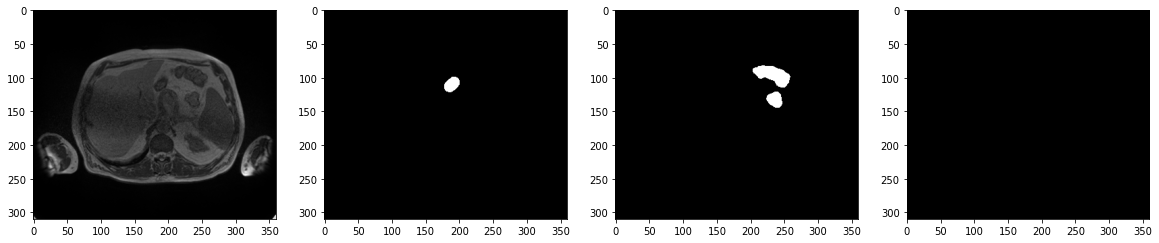

In [19]:
for idx, row in new_df[(new_df['stomach_rle'] != '')].iloc[20:21,:].iterrows():
    fig, axis = plt.subplots(1,4)
    image = cv2.imread(row['path'], cv2.IMREAD_UNCHANGED)
    axis[0].imshow(image, cmap='gray')
    axis[1].imshow(rle2mask(row['stomach_rle'], (int(row['width']), int(row['height']))), cmap='gray')
    axis[2].imshow(rle2mask(row['large_bowel_rle'], (int(row['width']), int(row['height']))), cmap='gray')
    axis[3].imshow(rle2mask(row['small_bowel_rle'], (int(row['width']), int(row['height']))), cmap='gray')
    print(row)

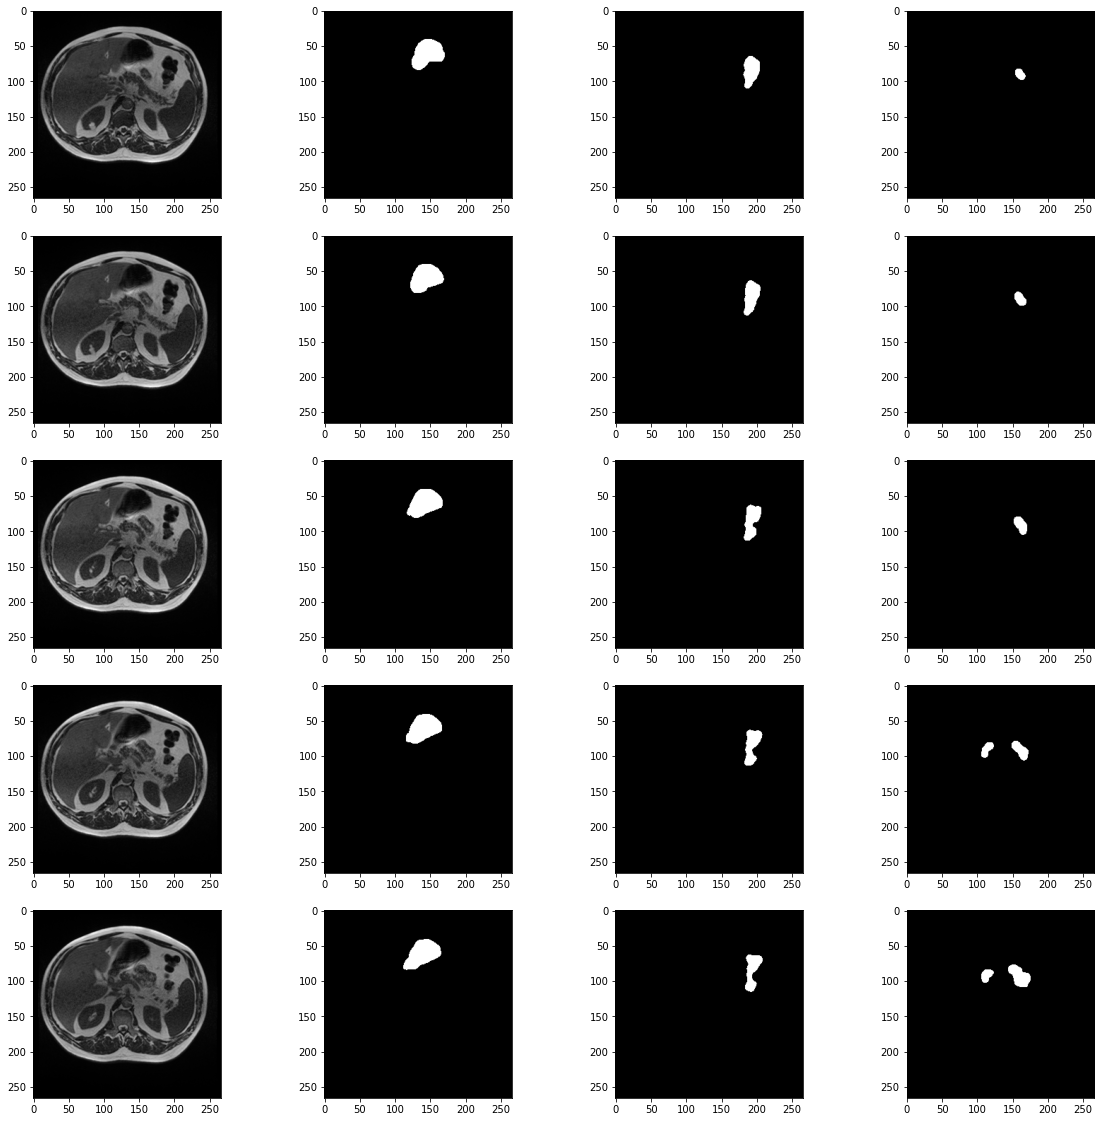

In [20]:
rcParams['figure.figsize'] = 20, 20
fig, axis = plt.subplots(5,4)
i = 0
for idx, row in new_df[new_df['stomach_rle'] != ''].iloc[18:23,:].iterrows():
    image = cv2.imread(row['path'], cv2.IMREAD_UNCHANGED)
    axis[i,0].imshow(image, cmap='gray')
    axis[i,1].imshow(rle2mask(row['stomach_rle'], (int(row['width']), int(row['height']))), cmap='gray')
    axis[i,2].imshow(rle2mask(row['large_bowel_rle'], (int(row['width']), int(row['height']))), cmap='gray')
    axis[i,3].imshow(rle2mask(row['small_bowel_rle'], (int(row['width']), int(row['height']))), cmap='gray')
    i += 1

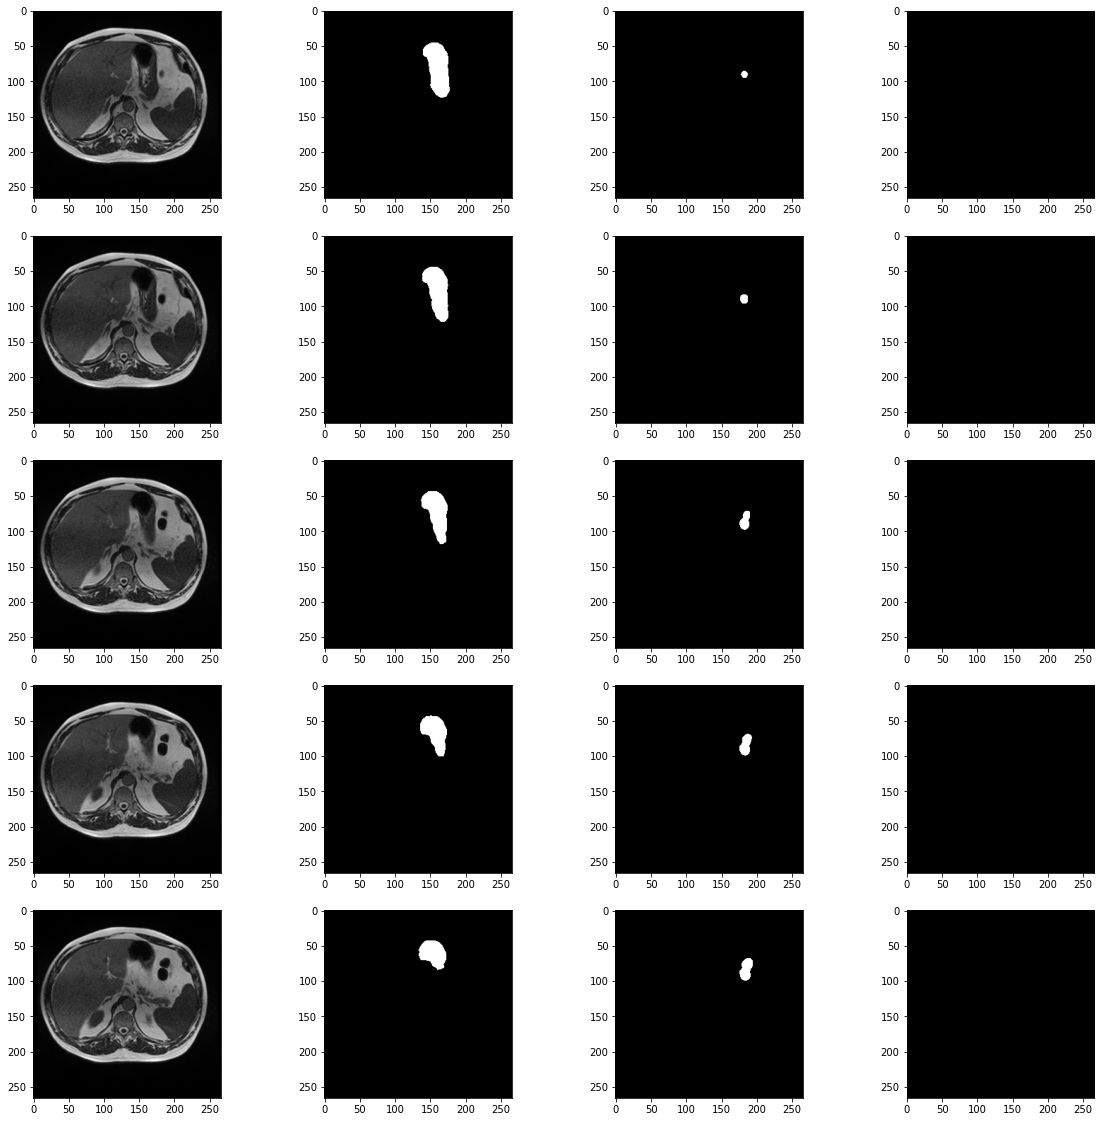

In [21]:
rcParams['figure.figsize'] = 20, 20
fig, axis = plt.subplots(5,4)
i = 0
for idx, row in new_df[new_df['stomach_rle'] != ''].iloc[10:15,:].iterrows():
    image = cv2.imread(row['path'], cv2.IMREAD_UNCHANGED)
    axis[i,0].imshow(image, cmap='gray')
    axis[i,1].imshow(rle2mask(row['stomach_rle'], (int(row['width']), int(row['height']))), cmap='gray')
    axis[i,2].imshow(rle2mask(row['large_bowel_rle'], (int(row['width']), int(row['height']))), cmap='gray')
    axis[i,3].imshow(rle2mask(row['small_bowel_rle'], (int(row['width']), int(row['height']))), cmap='gray')
    i += 1

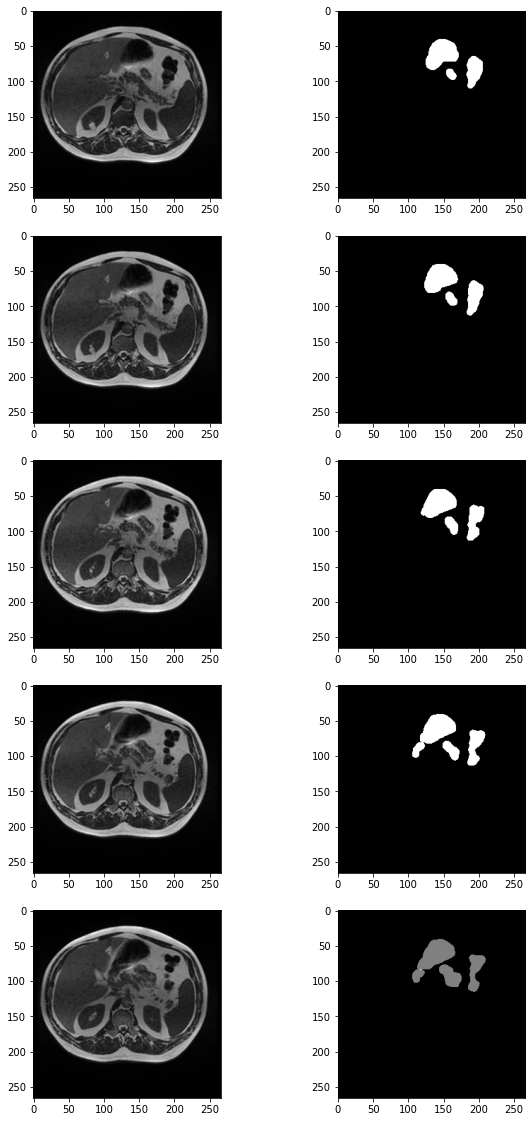

In [24]:
rcParams['figure.figsize'] = 10,20
fig, axis = plt.subplots(5,2)
i = 0
for idx, row in new_df[(new_df['stomach_rle'] != '')].iloc[18:23,:].iterrows():
    image = cv2.imread(row['path'], cv2.IMREAD_UNCHANGED)
    axis[i,0].imshow(image, cmap='gray')
    s_mask = rle2mask(row['stomach_rle'], (int(row['width']), int(row['height'])))
    lb_mask = rle2mask(row['large_bowel_rle'], (int(row['width']), int(row['height'])))
    sb_mask = rle2mask(row['small_bowel_rle'], (int(row['width']), int(row['height'])))
    
    mask = s_mask + lb_mask + sb_mask
    
    axis[i,1].imshow(mask, cmap='gray')
    i += 1
